# Step 1: Setup prerequisites

In [1]:
import os
from pymongo import MongoClient

In [2]:
MONGODB_URI = ""
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI, appname="devrel.workshop.agents")
# Check the connection to the server
mongodb_client.admin.command("ping")

{'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1747193356, 1),
  'signature': {'hash': b'R\x81\x1fqa\x9c\xb0\x19|\xc3\xdfN\xfa\xa4l\x9b\xf2))\x8a',
   'keyId': 7456513059255746561}},
 'operationTime': Timestamp(1747193356, 1)}

In [3]:
SERVERLESS_URL = ""
LLM_PROVIDER = "google"

# Step 2: Read PDF from URL

In [4]:
from io import BytesIO

import pymupdf
import requests

In [5]:
# Download the DeepSeek paper
response = requests.get("https://arxiv.org/pdf/2501.12948")
if response.status_code != 200:
    raise ValueError(f"Failed to download PDF. Status code: {response.status_code}")
# Load the response as an in-memory file-like object
pdf_stream = BytesIO(response.content)
# Open the object as a PDF document
pdf = pymupdf.open(stream=pdf_stream, filetype="pdf")

# Step 3: Store PDF images locally and extract metadata

In [6]:
from tqdm import tqdm

In [7]:
docs = []

In [8]:
zoom = 3.0
mat = pymupdf.Matrix(zoom, zoom)
# Iterate through the pages of the PDF
for n in tqdm(range(pdf.page_count)):
    temp = {}
    # Render the PDf as an image
    pix = pdf[n].get_pixmap(matrix=mat)
    # Store image locally
    key = f"{n+1}.png"
    pix.save(f"data/images/{key}")
    temp["key"] = key
    temp["width"] = pix.width
    temp["height"] = pix.height
    docs.append(temp)

100%|██████████| 22/22 [00:02<00:00,  9.40it/s]


# Step 4: Generate image embeddings

In [ ]:
# from voyageai import Client
# from PIL import Image

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# # Set Voyage AI API Key
# os.environ["VOYAGE_API_KEY"] = "your-api-key"

In [ ]:
# voyageai_client = Client()

In [ ]:
# def get_embedding(data, input_type):
#     """
#     Get Voyage AI embeddings for images and text.

#     Args:
#         data: An image or text to embed
#         input_type: Input type, either "document" or "query"

#     Returns: Embeddings as a list
#     """
#     embedding = voyageai_client.multimodal_embed(
#         inputs=[[data]], model="voyage-multimodal-3", input_type=input_type
#     ).embeddings[0]
#     return embedding

In [ ]:
# embedded_docs = []
# for doc in tqdm(docs):
#     # Open the image from file
#     img = Image.open(f"data/images/{doc['key']}")
#     # Add the embeddings to the document
#     doc["embedding"] = get_embedding(img, "document")
#     embedded_docs.append(doc)

# Step 5: Write embeddings and metadata to MongoDB

In [9]:
import json

In [10]:
#  Database name
DB_NAME = "mongodb_aiewf"
# Name of the collection with full documents- used for summarization
COLLECTION_NAME = "multimodal_workshop"

In [11]:
collection = mongodb_client[DB_NAME][COLLECTION_NAME]

In [12]:
with open("data/embeddings.json", "r") as data_file:
    json_data = data_file.read()
data = json.loads(json_data)

In [13]:
collection.delete_many({})
collection.insert_many(data)
print(
    f"{collection.count_documents({})} documents ingested into the {COLLECTION_NAME} collection."
)

22 documents ingested into the multimodal_workshop collection.


# Step 6: Create a vector search index

In [16]:
VS_INDEX_NAME = "vector_index"

In [17]:
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1024,
                "similarity": "cosine",
            }
        ]
    },
}

In [18]:
# Create a vector search index with the above `model` for the `collection` collection
collection.create_search_index(model=model)

'vector_index'

In [19]:
# Verify that the index is in READY status before proceeding
list(collection.list_search_indexes())

[{'id': '682391d77bacc306df6dd56f',
  'name': 'vector_index',
  'type': 'vectorSearch',
  'status': 'READY',
  'queryable': True,
  'latestDefinitionVersion': {'version': 0,
   'createdAt': datetime.datetime(2025, 5, 13, 18, 39, 19, 631000)},
  'latestDefinition': {'fields': [{'type': 'vector',
     'path': 'embedding',
     'numDimensions': 1024,
     'similarity': 'cosine'}]},
  'statusDetail': [{'hostname': 'atlas-upxkcz-shard-00-02',
    'status': 'READY',
    'queryable': True,
    'mainIndex': {'status': 'READY',
     'queryable': True,
     'definitionVersion': {'version': 0,
      'createdAt': datetime.datetime(2025, 5, 13, 18, 39, 19)},
     'definition': {'fields': [{'type': 'vector',
        'path': 'embedding',
        'numDimensions': 1024,
        'similarity': 'cosine'}]}}},
   {'hostname': 'atlas-upxkcz-shard-00-00',
    'status': 'READY',
    'queryable': True,
    'mainIndex': {'status': 'READY',
     'queryable': True,
     'definitionVersion': {'version': 0,
      '

# Step 7: Create agent tools


In [20]:
from langchain.agents import tool
from PIL import Image as Image
import base64

/Users/apoorva.joshi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/langchain/chains/api/base.py:56: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.utilities.requests import TextRequestsWrapper


In [21]:
def get_encoded_image(key):
    with open(key, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_image

### Vector Search

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/#ann-examples (Refer to the "Basic Example")

In [132]:
# Define a tool to retrieve relevant documents for a user query using vector search
@tool
def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embedding for the `user_query` using the `get_embedding` function defined above
    response = requests.post(
        url=SERVERLESS_URL,
        json={
            "task": "get_embedding",
            "data": {"input": user_query, "input_type": "query"},
        },
    )
    query_embedding = response.json()["embedding"]

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": "embedding",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 1,
            }
        },
        {
            "$project": {
                "_id": 0,
                "key": 1,
                "width": 1,
                "height": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    # Execute the aggregation `pipeline` against the `vs_collection` collection and store the results in `results`
    results = collection.aggregate(pipeline)
    # Get images from local storage
    images = []
    print("Keys retrieved:")
    for result in results:
        key = result["key"]
        print(key)
        images.append(
            {
                "type": "image_url",
                "image_url": f"data:image/png;base64,{get_encoded_image(f'data/images/{key}')}",
            }
        )
    return images

In [133]:
# Create the list of tools
tools = [get_information_for_question_answering]

### Test out the tools


In [134]:
# Test out the `get_information_for_question_answering` tool with the query "What are some best practices for data backups in MongoDB?"
# You should see a non-empty response
keys = get_information_for_question_answering.invoke(
    "Summarize the Pass@1 accuracy of Deepseek R1 against other models."
)

Keys retrieved:
1.png


# Step 8: Define graph state

In [135]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [136]:
# Define the graph state
# We are only tracking chat messages but you can track other attributes as well
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 9: Instantiate the LLM

In [137]:
from langchain_core.load import load
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [138]:
# Obtain the Langchain LLM object from our serverless endpoint
llm_dict = requests.post(
    url=SERVERLESS_URL, json={"task": "get_llm", "data": LLM_PROVIDER}
).json()
llm = load(llm_dict["llm"], secrets_map=llm_dict["secrets_map"])

In [139]:
# Create a Chain-of-Thought (CoT) prompt template for the agent.
# This includes a system prompt with a placeholder for tool names, and a placeholder for messages i.e. user queries and assistant responses
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful AI assistant.
            You are provided with a tool to answer questions about a piece of research.
            Think step-by-step and use this tool only when necessary to get the information required to answer the user query.
            Do not re-run tools unless absolutely necessary."
            If you don't have enough information to answer a question, reply with I DON'T KNOW.
            You have access to the following tools: {tool_names}.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [140]:
# Fill in the prompt template with the tool names
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

📚 https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/#binding-tool-schemas

In [141]:
# Bind the `tools` to the `llm` instantiated above
bind_tools = llm.bind_tools(tools)

📚 https://python.langchain.com/v0.1/docs/expression_language/primitives/sequence/#the-pipe-operator

In [142]:
# Chain the `prompt` with the tool-bound llm using the `|` operator
llm_with_tools = prompt | bind_tools

In [143]:
# Test that the LLM is makes a tool call to answer questions about the paper.
llm_with_tools.invoke(
    {
        "messages": [
            (
                "human",
                "Summarize the Pass@1 accuracy of Deepseek R1 against other models.",
            )
        ]
    }
).tool_calls

[{'name': 'get_information_for_question_answering',
  'args': {'user_query': 'Pass@1 accuracy of Deepseek R1 compared to other models'},
  'id': '877c71a3-9093-4e43-b92a-f38ef64bcc14',
  'type': 'tool_call'}]

In [144]:
# Test that the LLM is does not make a tool call to explain a given image.
llm_with_tools.invoke(
    {
        "messages": [
            (
                "human",
                [
                    {"type": "text", "text": "Explain the equation in this image."},
                    {
                        "type": "image_url",
                        "image_url": f"data:image/png;base64,{get_encoded_image('data/test.png')}",
                    },
                ],
            )
        ]
    }
).tool_calls

[]

# Step 10: Define graph nodes

In [145]:
from langchain_core.messages import AIMessage, ToolMessage
from pprint import pprint

In [146]:
# Define the agent node
def agent(state: GraphState):
    """
    Agent node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    # Get the messages from the graph `state`
    messages = state["messages"]
    # Invoke `llm_with_tools` with `messages` using the `invoke` method
    result = llm_with_tools.invoke(messages)
    return {"messages": [result]}

In [147]:
# Create a map of tool name to tool call
tools_by_name = {tool.name: tool for tool in tools}
pprint(tools_by_name)

{'get_information_for_question_answering': StructuredTool(name='get_information_for_question_answering', description="Retrieve information using vector search to answer a user query.\n\nArgs:\nuser_query (str): The user's query string.\n\nReturns:\nstr: The retrieved information formatted as a string.", args_schema=<class 'langchain_core.utils.pydantic.get_information_for_question_answering'>, func=<function get_information_for_question_answering at 0x16378d080>)}


In [160]:
# Define tool node
def tool_node(state: GraphState):
    """
    Tool node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    result = []
    # Get the list of tool calls from messages
    tool_calls = state["messages"][-1].tool_calls
    # Iterate through `tool_calls`
    for tool_call in tool_calls:
        # Get the tool from `tools_by_name` using the `name` attribute of the `tool_call`
        tool = tools_by_name[tool_call["name"]]
        # Invoke the `tool` using the `args` attribute of the `tool_call`
        description = [{"type": "text", "text": "Here are the images:"}]
        observation = tool.invoke(tool_call["args"])
        # Append the result of executing the tool to the `result` list as a ToolMessage
        # The `content` of the message is `observation` i.e. result of the tool call
        # The `tool_call_id` can be obtained from the `tool_call`
        result.append(
            ToolMessage(content=description + observation, tool_call_id=tool_call["id"])
        )
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": result}

# Step 11: Define conditional edges

In [161]:
from langgraph.graph import END

In [162]:
# Define a conditional routing function
def route_tools(state: GraphState):
    """
    Use in the conditional_edge to route to the tool node if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get messages from graph state
    messages = state.get("messages", [])
    if len(messages) > 0:
        # Get the last AI message from messages
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # Check if the last message has tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If yes, return "tools"
        return "tools"
    # If no, return END
    return END

# Step 12: Build the graph

In [163]:
from langgraph.graph import StateGraph, START
from IPython.display import Image as IPythonImage, display

In [164]:
# Instantiate the graph
graph = StateGraph(GraphState)

📚 https://blog.langchain.dev/langgraph/#nodes

In [165]:
# Add nodes to the `graph` using the `add_node` function
# Add a `agent` node. The `agent` node should run the `agent` function
graph.add_node("agent", agent)
# Add a `tools` node. The `tools` node should run the `tool_node` function
graph.add_node("tools", tool_node)

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#normal-edges

In [166]:
# Add fixed edges to the `graph` using the `add_edge` method
# Add an edge from the START node to the `agent` node
graph.add_edge(START, "agent")
# Add an edge from the `tools` node to the `agent` node
graph.add_edge("tools", "agent")

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges

In [167]:
# Use the `add_conditional_edges` method to add a conditional edge from the `agent` node to the `tools` node
# based on the output of the `route_tools` function
graph.add_conditional_edges(
    "agent",
    route_tools,
    {"tools": "tools", END: END},
)

In [168]:
# Compile the `graph`
app = graph.compile()

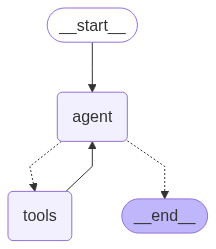

In [169]:
# Visualize the graph
try:
    display(IPythonImage(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Step 13: Execute the graph

In [170]:
# Stream outputs from the graph as they pass through its nodes
def execute_graph(user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        user_input (str): User query string
    """
    # Add user input to the messages attribute of the graph state
    # The role of the message should be "user" and content should be `user_input`
    input = {"messages": [("human", user_input)]}
    # Pass input to the graph and stream the outputs
    for output in app.stream(input):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_information_for_question_answering', 'arguments': '{"user_query": "Pass@1 accuracy of Deepseek R1 compared to other models"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d39b1835-b95c-4dfd-8457-533c0588b295-0', tool_calls=[{'name': 'get_information_for_question_answering', 'args': {'user_query': 'Pass@1 accuracy of Deepseek R1 compared to other models'}, 'id': '651771c5-5c53-41c3-8904-b2dbc430e6df', 'type': 'tool_call'}], usage_metadata={'input_tokens': 182, 'output_tokens': 26, 'total_tokens': 208, 'input_token_details': {'cache_read': 0}})]}
Keys retrieved:
1.png
Node tools:
{'messages': [ToolMessage(content=[{'type': 'text', 'text': 'Here are the images:'}, {'type': 'image_url', 'image_url': ''}], id='70e6863e-ff29-4b12-832c-ba18b6090acb', tool_call_id='651771c5-5c53-41c3-8904-b2dbc430e6df')]
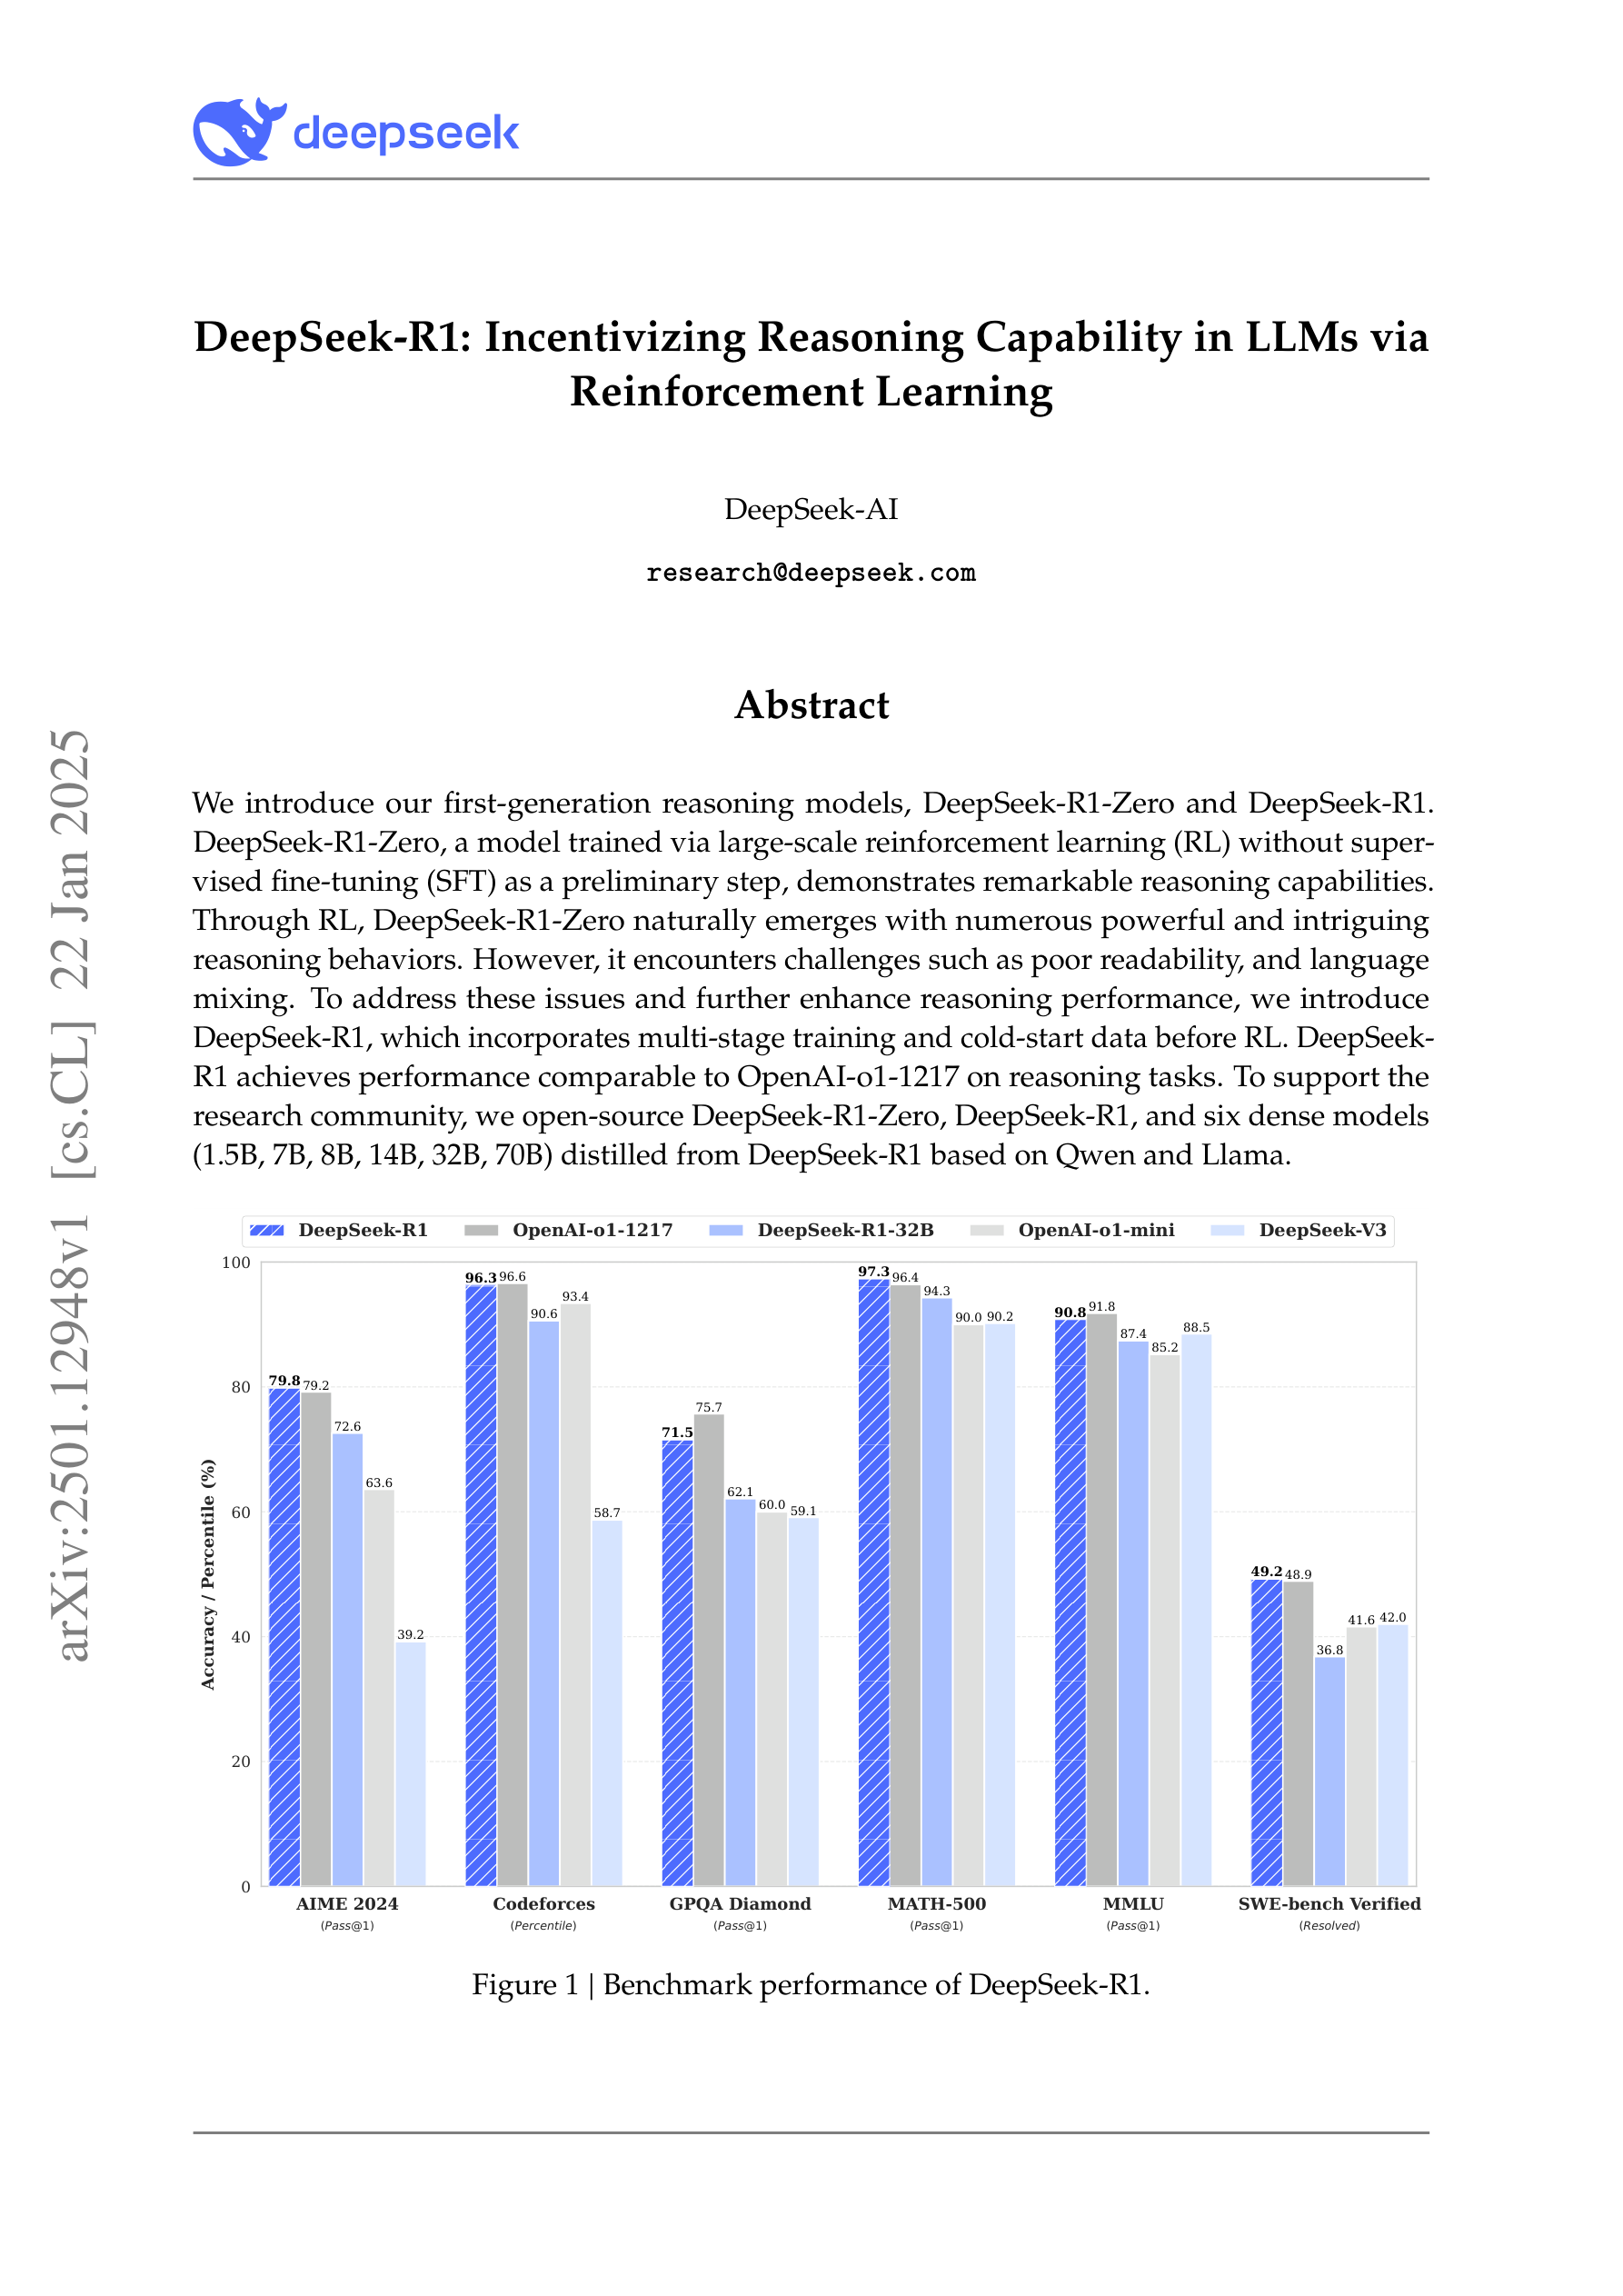

In [171]:
# Test the graph execution to view end-to-end flow
execute_graph("Summarize the Pass@1 accuracy of Deepseek R1 against other models.")

In [172]:
execute_graph(
    [
        {"type": "text", "text": "Explain the graph in the image."},
        {
            "type": "image_url",
            "image_url": f"data:image/png;base64,{get_encoded_image('data/test.png')}",
        },
    ]
)

Node agent:
{'messages': [AIMessage(content='The graph shows the benchmark performance of DeepSeek-R1 compared to other models (OpenAI-01-1217, DeepSeek-R1-32B, OpenAI-01-mini, and DeepSeek-V3) on several tasks: AIME 2024, Codeforces, GPQA Diamond, MATH-500, MMLU, and SWE-bench Verified. The y-axis represents accuracy or percentile, depending on the task. The x-axis lists the different tasks. Each task has a group of bars representing the performance of each model. DeepSeek-R1 is represented by the blue bar with diagonal lines. The specific metric used for each task (e.g., Pass@1, Percentile, Resolved) is indicated in parentheses below the task name.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5be3a1d1-1875-45f8-ac63-01c768b08eb3-0', usage_metadata={'input_tokens': 1979, 'output_tokens': 171, 'total_tokens': 2150, 'input_token_details': {'cache_read': 0}})]}
---FINAL ANS

# Step 11: Add memory to the agent

In [173]:
from langgraph.checkpoint.mongodb import MongoDBSaver

In [174]:
# Initialize a MongoDB checkpointer
checkpointer = MongoDBSaver(mongodb_client)

In [175]:
# Instantiate the graph with the checkpointer
app = graph.compile(checkpointer=checkpointer)

📚 https://langchain-ai.github.io/langgraph/concepts/persistence/#threads

In [176]:
def execute_graph(thread_id: str, user_input):
    """
    Stream outputs from the graph

    Args:
        thread_id (str): Thread ID for the checkpointer
        user_input (str): User query string
    """
    # Add user input to the messages attribute of the graph state
    # The role of the message should be "user" and content should be `user_input`
    input = {"messages": [("human", user_input)]}
    # Define a config containing the thread ID
    config = {"configurable": {"thread_id": thread_id}}
    # Pass `input` and `config` to the graph and stream outputs
    for output in app.stream(input, config):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_information_for_question_answering', 'arguments': '{"user_query": "Pass@1 accuracy of Deepseek R1 compared to other models"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-280be4c4-c74f-4b72-b617-eced5f71ab66-0', tool_calls=[{'name': 'get_information_for_question_answering', 'args': {'user_query': 'Pass@1 accuracy of Deepseek R1 compared to other models'}, 'id': 'b1f2e3a4-cce6-4bcc-b6b0-045cf608b316', 'type': 'tool_call'}], usage_metadata={'input_tokens': 182, 'output_tokens': 26, 'total_tokens': 208, 'input_token_details': {'cache_read': 0}})]}
Keys retrieved:
1.png
Node tools:
{'messages': [ToolMessage(content=[{'type': 'text', 'text': 'Here are the images:'}, {'type': 'image_url', 'image_url': ''}], id='c73fe36c-f76a-444f-9d94-a5bcab5090b8', tool_call_id='b1f2e3a4-cce6-4bcc-b6b0-045cf608b316')]
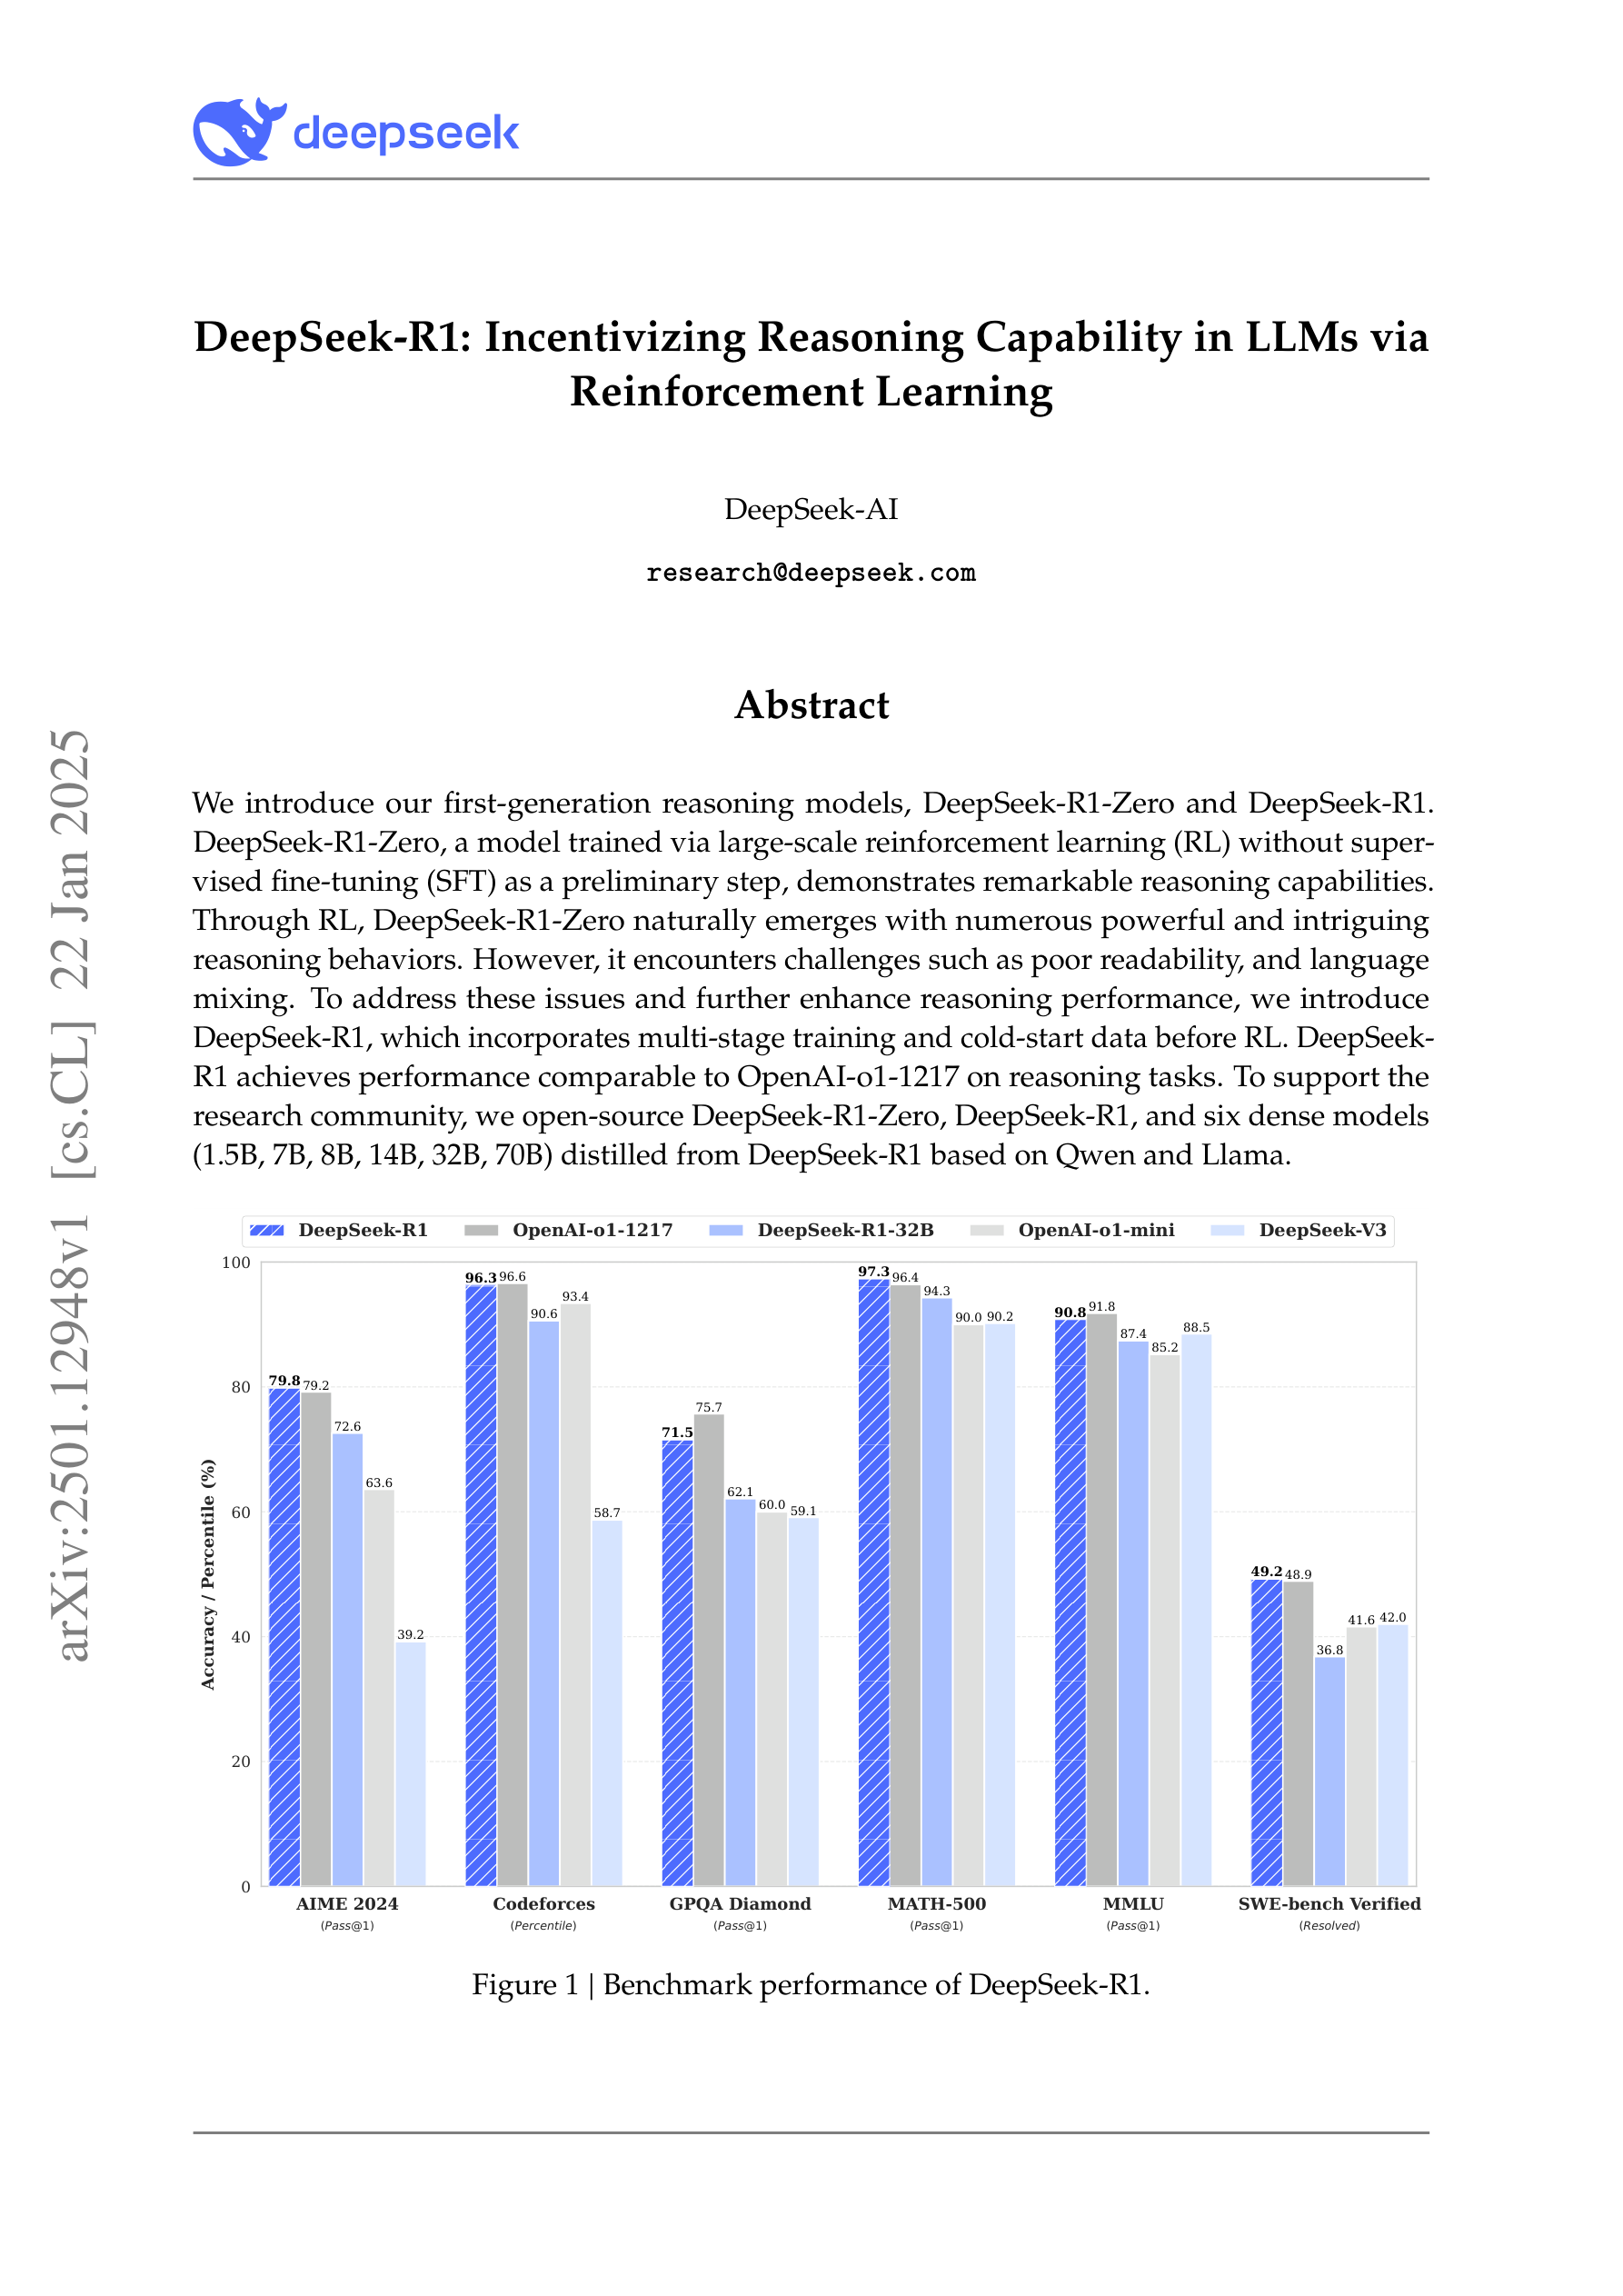

In [177]:
# Test graph execution with thread ID
execute_graph("6", "Summarize the Pass@1 accuracy of Deepseek R1 against other models.")

In [179]:
# Follow-up question to ensure message history works
execute_graph(
    "6",
    "What did I just ask you?",
)

Node agent:
{'messages': [AIMessage(content='You asked me to summarize the Pass@1 accuracy of Deepseek R1 against other models.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-88f94f2d-60c2-45d9-85c4-8d95514fdcdc-0', usage_metadata={'input_tokens': 290613, 'output_tokens': 20, 'total_tokens': 290633, 'input_token_details': {'cache_read': 0}})]}
---FINAL ANSWER---
You asked me to summarize the Pass@1 accuracy of Deepseek R1 against other models.
